# US Job Salary Prediction

## Importing Libraries

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from sklearn.preprocessing import PowerTransformer
from category_encoders import TargetEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')


## Loading Train Data

In [2]:
train_data=pd.read_csv("usjobs_train.csv")
train_data.head()

,ID,Job,Jobs_Group,Profile,Remote,Company,Location,City,State,Frecuency_Salary,...,Skills,Sector,Sector_Group,Revenue,Employee,Company_Score,Reviews,Director,Director_Score,URL
0,job_f2c807527f687b96,"Part-time Reporting Business Analyst, Data & A...",Financial Analyst,NaN,Remote,Sandy Hook Promise Foundation,Remote,NaN,NaN,hour,...,"['Salesforce', 'Bachelor']",NGOs and Nonprofit Organizations,Nonprofit Organizations,NaN,XS,4.2,20.0,NaN,NaN,https://www.sandyhookpromise.org/
1,job_2660d4c53505af10,Controller,Controller,NaN,NaN,Building Service 32BJ Benefit Funds,"New York, NY 10013 (Tribeca area)",New York,NY,year,...,"['SQL', 'Master', 'Dynamics 365', 'Snowflake',...",NGOs and Nonprofit Organizations,Nonprofit Organizations,NaN,M,3.5,58.0,"Peter Goldberger, Executive Director",0.70,NaN
2,sj_50358c44328ae06a,Sr Finance Analyst,Financial Analyst,Senior,NaN,LCS,NaN,NaN,NaN,year,...,"['Word', 'Bachelor', 'Excel']",Personal Consumer Services,Sales,XXXS,XXXS,3.4,88.0,NaN,NaN,NaN
3,job_a087fd700e3e85f0,Senior Business Intelligence Analyst,Business Intelligence,Senior,Hybrid,Federal Reserve Bank of Richmond,"Richmond, VA 23219 (Central Office area)",Richmond,VA,year,...,"['PowerPoint', 'Power BI', 'Tableau', 'Word', ...",Banking and Credit Services,Finance,XXL,XL,3.8,30.0,Tom Barkin,0.70,https://www.richmondfed.org/
4,job_d2a2538a2c4d2033,Data Center Operations Analyst (Temporary Assi...,Operations Analyst,NaN,Remote,Los Angeles County Office of Education,"Downey, CA 90242+1 ubicación",Downey,CA,hour,...,['Office'],State and Regional Agencies,Government,NaN,XL,4.2,186.0,Debra Duardo,0.85,NaN


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33248 entries, 0 to 33247
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                33248 non-null  object 
 1   Job               33248 non-null  object 
 2   Jobs_Group        33248 non-null  object 
 3   Profile           12141 non-null  object 
 4   Remote            13929 non-null  object 
 5   Company           33239 non-null  object 
 6   Location          33235 non-null  object 
 7   City              29424 non-null  object 
 8   State             30136 non-null  object 
 9   Frecuency_Salary  33248 non-null  object 
 10  Mean_Salary       33248 non-null  float64
 11  Skills            33248 non-null  object 
 12  Sector            26034 non-null  object 
 13  Sector_Group      26034 non-null  object 
 14  Revenue           14930 non-null  object 
 15  Employee          20449 non-null  object 
 16  Company_Score     24486 non-null  float6

In [4]:
train_data.isna().sum()

ID                      0
Job                     0
Jobs_Group              0
Profile             21107
Remote              19319
Company                 9
Location               13
City                 3824
State                3112
Frecuency_Salary        0
Mean_Salary             0
Skills                  0
Sector               7214
Sector_Group         7214
Revenue             18318
Employee            12799
Company_Score        8762
Reviews              8762
Director            20785
Director_Score      21924
URL                 16033
dtype: int64

In [5]:
train_data.shape

(33248, 21)

In [6]:
missing_percentage = (train_data.isnull().sum() / len(train_data)) * 100
missing_percentage

ID                   0.000000
Job                  0.000000
Jobs_Group           0.000000
Profile             63.483518
Remote              58.105751
Company              0.027069
Location             0.039100
City                11.501444
State                9.359962
Frecuency_Salary     0.000000
Mean_Salary          0.000000
Skills               0.000000
Sector              21.697546
Sector_Group        21.697546
Revenue             55.095043
Employee            38.495549
Company_Score       26.353465
Reviews             26.353465
Director            62.515038
Director_Score      65.940808
URL                 48.222449
dtype: float64

In [7]:
# List of columns to drop based on high missing data or low relevance
columns_to_drop = ['Profile', 'Remote', 'Revenue', 'Employee', 'Director', 'Director_Score', 'URL']

# Drop the columns from the dataset
train_data = train_data.drop(columns=columns_to_drop)

# Show the cleaned dataset
train_data.head()


,ID,Job,Jobs_Group,Company,Location,City,State,Frecuency_Salary,Mean_Salary,Skills,Sector,Sector_Group,Company_Score,Reviews
0,job_f2c807527f687b96,"Part-time Reporting Business Analyst, Data & A...",Financial Analyst,Sandy Hook Promise Foundation,Remote,NaN,NaN,hour,115000.0,"['Salesforce', 'Bachelor']",NGOs and Nonprofit Organizations,Nonprofit Organizations,4.2,20.0
1,job_2660d4c53505af10,Controller,Controller,Building Service 32BJ Benefit Funds,"New York, NY 10013 (Tribeca area)",New York,NY,year,185000.0,"['SQL', 'Master', 'Dynamics 365', 'Snowflake',...",NGOs and Nonprofit Organizations,Nonprofit Organizations,3.5,58.0
2,sj_50358c44328ae06a,Sr Finance Analyst,Financial Analyst,LCS,NaN,NaN,NaN,year,84500.0,"['Word', 'Bachelor', 'Excel']",Personal Consumer Services,Sales,3.4,88.0
3,job_a087fd700e3e85f0,Senior Business Intelligence Analyst,Business Intelligence,Federal Reserve Bank of Richmond,"Richmond, VA 23219 (Central Office area)",Richmond,VA,year,111625.0,"['PowerPoint', 'Power BI', 'Tableau', 'Word', ...",Banking and Credit Services,Finance,3.8,30.0
4,job_d2a2538a2c4d2033,Data Center Operations Analyst (Temporary Assi...,Operations Analyst,Los Angeles County Office of Education,"Downey, CA 90242+1 ubicación",Downey,CA,hour,102690.4,['Office'],State and Regional Agencies,Government,4.2,186.0


In [8]:
missing_percentage = (train_data.isnull().sum() / len(train_data)) * 100
missing_percentage

ID                   0.000000
Job                  0.000000
Jobs_Group           0.000000
Company              0.027069
Location             0.039100
City                11.501444
State                9.359962
Frecuency_Salary     0.000000
Mean_Salary          0.000000
Skills               0.000000
Sector              21.697546
Sector_Group        21.697546
Company_Score       26.353465
Reviews             26.353465
dtype: float64

### Filling Missing Values

In [9]:
# Fill missing 'City' first based on the most common city for each state
train_data['City'] = train_data.groupby('State')['City'].transform(lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else 'Unknown')

# Now fill missing 'State' based on the most common state for each city
train_data['State'] = train_data.groupby('City')['State'].transform(lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else 'Unknown')

# If any missing values remain, replace them with 'Unknown'
train_data['City'].fillna("Unknown", inplace=True)
train_data['State'].fillna("Unknown", inplace=True)

# Verify missing values
print(train_data[['City', 'State']].isnull().sum())


City     0
State    0
dtype: int64


In [10]:
# Fill missing values in categorical columns with 'Unknown'
train_data['Company'].fillna(train_data['Company'].mode()[0], inplace=True)
train_data['Location'].fillna(train_data['Location'].mode()[0], inplace=True)

train_data['Sector'].fillna("Unknown", inplace=True)
train_data['Sector_Group'].fillna("Unknown", inplace=True)

# Fill missing values in numerical columns
train_data['Company_Score'].fillna(train_data['Company_Score'].median(), inplace=True)
train_data['Reviews'].fillna(0, inplace=True)

# Verify that there are no missing values left
print(train_data.isnull().sum())

ID                  0
Job                 0
Jobs_Group          0
Company             0
Location            0
City                0
State               0
Frecuency_Salary    0
Mean_Salary         0
Skills              0
Sector              0
Sector_Group        0
Company_Score       0
Reviews             0
dtype: int64


In [11]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Define the numerical columns
# numerical_columns = ['Mean_Salary', 'Company_Score', 'Reviews']

# # Plot the distributions of the columns
# plt.figure(figsize=(14, 5))

# for i, col in enumerate(numerical_columns, 1):
#     plt.subplot(1, 3, i)  # Arrange subplots in one row
#     sns.histplot(train_data[col].dropna(), kde=True, color='blue')
#     plt.title(f'{col} Distribution')

# plt.tight_layout()
# plt.show()


In [12]:
# # Define the numerical columns
# numerical_columns = ['Mean_Salary', 'Company_Score', 'Reviews']

# # Apply PowerTransformer (Box-Cox or Yeo-Johnson depending on the data)
# transformer = PowerTransformer(method='yeo-johnson')  # Use 'box-cox' if your data has only positive values

# # Transform the selected columns
# train_data[numerical_columns] = transformer.fit_transform(train_data[numerical_columns])

# # Plot the distributions after the transformation
# plt.figure(figsize=(14, 5))

# for i, col in enumerate(numerical_columns, 1):
#     plt.subplot(1, 3, i)  # Arrange subplots in one row
#     sns.histplot(train_data[col].dropna(), kde=True, color='blue')
#     plt.title(f'{col} Distribution After Transformation')

# plt.tight_layout()
# plt.show()


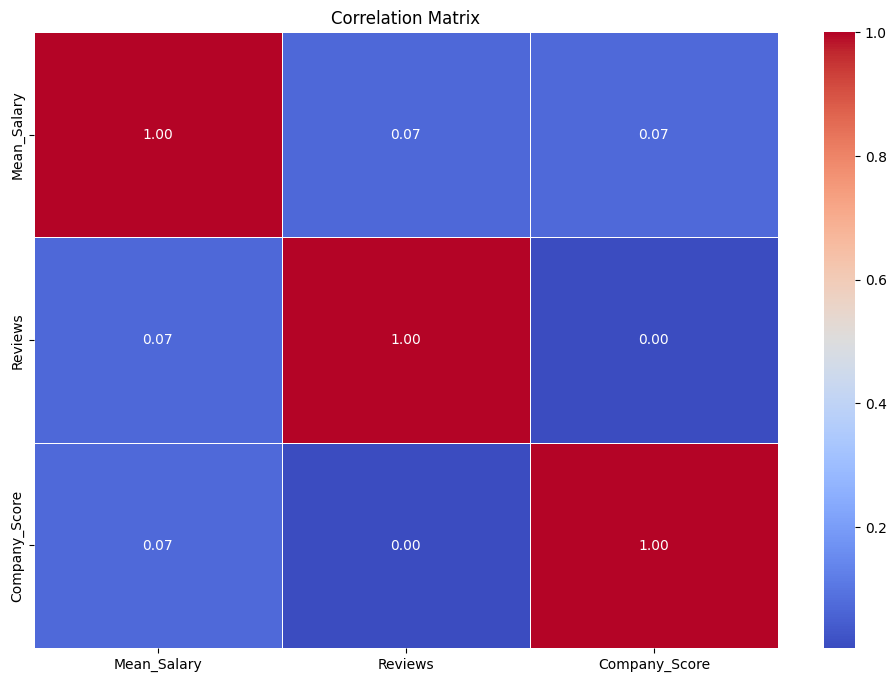

In [13]:
# List of numerical columns for correlation
numerical_columns = ['Mean_Salary', 'Reviews', 'Company_Score']

# Calculate the correlation matrix
correlation_matrix = train_data[numerical_columns].corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [14]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Plot boxplot for numerical columns
# numerical_columns = ['Mean_Salary', 'Reviews','Company_Score']  # Add other numerical columns if needed

# plt.figure(figsize=(14, 8))

# for i, col in enumerate(numerical_columns, 1):
#     plt.subplot(1, len(numerical_columns), i)
#     sns.boxplot(x=train_data[col])
#     plt.title(f'{col} Boxplot')

# plt.tight_layout()
# plt.show()


In [15]:
# numerical_columns = ['Mean_Salary', 'Reviews', 'Company_Score']

# for col in numerical_columns:
#     Q1 = train_data[col].quantile(0.25)
#     Q3 = train_data[col].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
    
#     outliers = train_data[(train_data[col] < lower_bound) | (train_data[col] > upper_bound)]
#     print(f"{col} has {outliers.shape[0]} outliers")


In [16]:
# from sklearn.preprocessing import RobustScaler

# scaler = RobustScaler()
# train_data[['Mean_Salary', 'Company_Score']] = scaler.fit_transform(train_data[['Mean_Salary', 'Company_Score']])


In [17]:
# List of remaining categorical columns after dropping unnecessary ones
categorical_columns = ['Job', 'Jobs_Group', 'Company', 'Location', 'City', 'State', 'Frecuency_Salary', 'Skills', 'Sector', 'Sector_Group']

# Find the number of unique values for each categorical column
for col in categorical_columns:
    print(f'{col} has {train_data[col].nunique()} unique values')


Job has 17227 unique values
Jobs_Group has 14 unique values
Company has 13995 unique values
Location has 12542 unique values
City has 2952 unique values
State has 55 unique values
Frecuency_Salary has 5 unique values
Skills has 10805 unique values
Sector has 139 unique values
Sector_Group has 29 unique values


# Encoding


In [18]:
# pip install category_encoders


In [19]:
# 1. Handle missing values for categorical columns before encoding
train_data['Job'].fillna(train_data['Job'].mode()[0], inplace=True)
train_data['Company'].fillna(train_data['Company'].mode()[0], inplace=True)
train_data['Location'].fillna(train_data['Location'].mode()[0], inplace=True)
train_data['City'].fillna(train_data['City'].mode()[0], inplace=True)

# 2. Target Encoding for high cardinality features with smoothing
target_encoder = ce.TargetEncoder(cols=['Job', 'Company', 'Location', 'City'], smoothing=10)
train_data[['Job', 'Company', 'Location', 'City']] = target_encoder.fit_transform(
    train_data[['Job', 'Company', 'Location', 'City']], train_data['Mean_Salary'])

# 3. One-Hot Encoding for moderate cardinality features
train_data = pd.get_dummies(train_data, columns=['Jobs_Group', 'State', 'Frecuency_Salary', 'Sector', 'Sector_Group'], drop_first=True)

# 4. TF-IDF Encoding for Skills column (text data)
train_data['Skills'].fillna('', inplace=True)  # Ensure no missing values in 'Skills' column
vectorizer = TfidfVectorizer(max_features=100)
skills_tfidf = vectorizer.fit_transform(train_data['Skills']).toarray()

# Create DataFrame for TF-IDF features
skills_df = pd.DataFrame(skills_tfidf, columns=vectorizer.get_feature_names_out())

# Concatenate the TF-IDF features with the original dataset and drop the original 'Skills' column
train_data = pd.concat([train_data, skills_df], axis=1).drop(columns=['Skills'])

# Check the transformed dataset
print(train_data.head())


                     ID            Job        Company       Location  \
0  job_f2c807527f687b96  106247.718642  106247.718642  110511.449933   
1  job_2660d4c53505af10  112256.398595  113419.430269  112863.432083   
2   sj_50358c44328ae06a  102074.870218  101439.551648  110511.449933   
3  job_a087fd700e3e85f0  118972.160554  102622.138688  103629.998799   
4  job_d2a2538a2c4d2033  104646.135366  105601.032360  105601.032360   

            City  Mean_Salary  Company_Score  Reviews  \
0  110652.048183     115000.0            4.2     20.0   
1  122635.016085     185000.0            3.5     58.0   
2  110652.048183      84500.0            3.4     88.0   
3   90752.233046     111625.0            3.8     30.0   
4  107300.908206     102690.4            4.2    186.0   

   Jobs_Group_Business Analyst  Jobs_Group_Business Intelligence  ...     sql  \
0                        False                             False  ...  0.0000   
1                        False                             Fal

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_data_scaled = train_data.copy()  # Copy to avoid altering original data
train_data_scaled[numerical_columns] = scaler.fit_transform(train_data[numerical_columns])


# Test Data


In [21]:
test_data=pd.read_csv("usjobs_test.csv")
test_data.head()

,ID,Job,Jobs_Group,Profile,Remote,Company,Location,City,State,Frecuency_Salary,Skills,Sector,Sector_Group,Revenue,Employee,Company_Score,Reviews,Director,Director_Score,URL
0,sj_99ad4f80ae7f4835,Business Analyst Manager,Business Analyst,Lead,Remote,Dryden Mutual Insurance Company,"Dryden, NY 13053",Dryden,NY,year,"['PowerPoint', 'Office', 'Excel', 'Agile']",Insurance Companies and Investment Societies,Insurance,NaN,NaN,5.0,2.0,NaN,NaN,NaN
1,job_6ff7f1a7c400916a,Senior Program Budget Analyst,Financial Analyst,Senior,NaN,Esphera Concepts,"Washington, DC+1 location",Washington,DC,year,"['PowerPoint', 'Master', 'Word', 'Bachelor', '...",Management and Consulting,Consulting,NaN,XS,NaN,NaN,NaN,NaN,https://www.espheraconcepts.com/
2,job_e059d20eba88b17a,Senior AI Engineer - Multi-year CONTRACT ROLE ...,ML/AI Engineer,Senior,Hybrid,Volkswagen Group of America - Chattanooga...,"Belmont, CA",Belmont,CA,year,"['Tensor Flow', 'Python', 'Master', 'PhD', 'C+...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,job_79f7953813b13358,"Data Scientist, Algorithmic Recommendations",Data Scientist,NaN,Remote,The New York Times,Remote,NaN,NaN,year,"['Google Cloud', 'Python', 'SQL', 'PhD']",Audiovisual and Media Communications,Media Communications,XL,XL,4.0,275.0,Meredith Kopit Levien,0.78,https://www.nytimes.com/
4,job_892dfe86b96f322b,Management & Budget Analyst-Finance,Financial Analyst,NaN,NaN,Metropolitan Government of Nashville & Davidso...,"Nashville, TN",Nashville,TN,year,"['PowerPoint', 'Master', 'Word', 'Excel', 'Bac...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# List of columns to drop based on high missing data or low relevance
columns_to_drop = ['Profile', 'Remote', 'Revenue', 'Employee', 'Director', 'Director_Score', 'URL']

# Drop the columns from the dataset
test_data = test_data.drop(columns=columns_to_drop)

# Show the cleaned dataset
test_data.head()


,ID,Job,Jobs_Group,Company,Location,City,State,Frecuency_Salary,Skills,Sector,Sector_Group,Company_Score,Reviews
0,sj_99ad4f80ae7f4835,Business Analyst Manager,Business Analyst,Dryden Mutual Insurance Company,"Dryden, NY 13053",Dryden,NY,year,"['PowerPoint', 'Office', 'Excel', 'Agile']",Insurance Companies and Investment Societies,Insurance,5.0,2.0
1,job_6ff7f1a7c400916a,Senior Program Budget Analyst,Financial Analyst,Esphera Concepts,"Washington, DC+1 location",Washington,DC,year,"['PowerPoint', 'Master', 'Word', 'Bachelor', '...",Management and Consulting,Consulting,NaN,NaN
2,job_e059d20eba88b17a,Senior AI Engineer - Multi-year CONTRACT ROLE ...,ML/AI Engineer,Volkswagen Group of America - Chattanooga...,"Belmont, CA",Belmont,CA,year,"['Tensor Flow', 'Python', 'Master', 'PhD', 'C+...",NaN,NaN,NaN,NaN
3,job_79f7953813b13358,"Data Scientist, Algorithmic Recommendations",Data Scientist,The New York Times,Remote,NaN,NaN,year,"['Google Cloud', 'Python', 'SQL', 'PhD']",Audiovisual and Media Communications,Media Communications,4.0,275.0
4,job_892dfe86b96f322b,Management & Budget Analyst-Finance,Financial Analyst,Metropolitan Government of Nashville & Davidso...,"Nashville, TN",Nashville,TN,year,"['PowerPoint', 'Master', 'Word', 'Excel', 'Bac...",NaN,NaN,NaN,NaN


In [23]:
test_data.isna().sum()

ID                     0
Job                    0
Jobs_Group             0
Company               10
Location               8
City                2625
State               2119
Frecuency_Salary       0
Skills                 0
Sector              4735
Sector_Group        4735
Company_Score       5828
Reviews             5828
dtype: int64

In [24]:
# Fill missing 'City' first based on the most common city for each state
test_data['City'] = test_data.groupby('State')['City'].transform(lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else 'Unknown')

# Now fill missing 'State' based on the most common state for each city
test_data['State'] = test_data.groupby('City')['State'].transform(lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else 'Unknown')

# If any missing values remain, replace them with 'Unknown'
test_data['City'].fillna("Unknown", inplace=True)
test_data['State'].fillna("Unknown", inplace=True)

# Verify missing values
print(test_data[['City', 'State']].isnull().sum())


City     0
State    0
dtype: int64


In [25]:
# Fill missing values in categorical columns with 'Unknown'
test_data['Company'].fillna(test_data['Company'].mode()[0], inplace=True)
test_data['Location'].fillna(test_data['Location'].mode()[0], inplace=True)

test_data['Sector'].fillna("Unknown", inplace=True)
test_data['Sector_Group'].fillna("Unknown", inplace=True)

# Fill missing values in numerical columns
test_data['Company_Score'].fillna(test_data['Company_Score'].median(), inplace=True)
test_data['Reviews'].fillna(0, inplace=True)

# Verify that there are no missing values left
print(test_data.isnull().sum())

ID                  0
Job                 0
Jobs_Group          0
Company             0
Location            0
City                0
State               0
Frecuency_Salary    0
Skills              0
Sector              0
Sector_Group        0
Company_Score       0
Reviews             0
dtype: int64


In [26]:
# # Define the numerical columns
# numerical_columns = ['Company_Score', 'Reviews']

# # Apply PowerTransformer (Box-Cox or Yeo-Johnson depending on the data)
# transformer = PowerTransformer(method='yeo-johnson')  # Use 'box-cox' if your data has only positive values

# # Transform the selected columns
# test_data[numerical_columns] = transformer.fit_transform(test_data[numerical_columns])

# # Plot the distributions after the transformation
# plt.figure(figsize=(14, 5))

# for i, col in enumerate(numerical_columns, 1):
#     plt.subplot(1, 3, i)  # Arrange subplots in one row
#     sns.histplot(train_data[col].dropna(), kde=True, color='blue')
#     plt.title(f'{col} Distribution After Transformation')

# plt.tight_layout()
# plt.show()


In [27]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Plot boxplot for numerical columns
# numerical_columns = ['Reviews','Company_Score']  # Add other numerical columns if needed

# plt.figure(figsize=(14, 8))

# for i, col in enumerate(numerical_columns, 1):
#     plt.subplot(1, len(numerical_columns), i)
#     sns.boxplot(x=train_data[col])
#     plt.title(f'{col} Boxplot')

# plt.tight_layout()
# plt.show()


In [28]:
# numerical_columns = ['Reviews', 'Company_Score']

# for col in numerical_columns:
#     Q1 = train_data[col].quantile(0.25)
#     Q3 = train_data[col].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
    
#     outliers = test_data[(test_data[col] < lower_bound) | (test_data[col] > upper_bound)]
#     print(f"{col} has {outliers.shape[0]} outliers")


In [29]:
# 1. Handle missing values for categorical columns before encoding
test_data['Job'].fillna(test_data['Job'].mode()[0], inplace=True)
test_data['Company'].fillna(test_data['Company'].mode()[0], inplace=True)
test_data['Location'].fillna(test_data['Location'].mode()[0], inplace=True)
test_data['City'].fillna(test_data['City'].mode()[0], inplace=True)

# 2. Target Encoding for high cardinality features in test data (same encoder used as train)
test_data[['Job', 'Company', 'Location', 'City']] = target_encoder.transform(
    test_data[['Job', 'Company', 'Location', 'City']])

# 3. One-Hot Encoding for moderate cardinality features in test data (same as train)
test_data = pd.get_dummies(test_data, columns=['Jobs_Group', 'State', 'Frecuency_Salary', 'Sector', 'Sector_Group'], drop_first=True)

# 4. TF-IDF Encoding for Skills column in test data (same vectorizer used as train)
test_data['Skills'].fillna('', inplace=True)  # Ensure no missing values in 'Skills' column
skills_tfidf_test = vectorizer.transform(test_data['Skills']).toarray()

# Create DataFrame for TF-IDF features in test data
skills_df_test = pd.DataFrame(skills_tfidf_test, columns=vectorizer.get_feature_names_out())

# Concatenate the TF-IDF features with the original dataset and drop the original 'Skills' column
test_data = pd.concat([test_data, skills_df_test], axis=1).drop(columns=['Skills'])

# Check the transformed test dataset
print(test_data.head())


                     ID            Job        Company       Location  \
0   sj_99ad4f80ae7f4835  103830.799867  104176.391730  104176.391730   
1  job_6ff7f1a7c400916a  104938.652004  104938.652004  105707.194924   
2  job_e059d20eba88b17a  104938.652004  108702.861226  111998.513208   
3  job_79f7953813b13358  104938.652004  103716.581219  110511.449933   
4  job_892dfe86b96f322b  104938.652004  100928.613584  107871.870009   

            City  Company_Score  Reviews  Jobs_Group_Business Analyst  \
0  104176.391730            5.0      2.0                         True   
1  117131.229948            3.7      0.0                        False   
2  110079.649174            3.7      0.0                        False   
3  110652.048183            4.0    275.0                        False   
4   95870.558518            3.7      0.0                        False   

   Jobs_Group_Business Intelligence  Jobs_Group_CFO  ...       sql  ssas  \
0                             False           False 

In [30]:
# Define features (X) and target (y) for training data
X_train = train_data.drop(columns=['ID', 'Mean_Salary'])  # Drop ID and target (Mean_Salary)
y_train = train_data['Mean_Salary']  # Target is the Mean_Salary column

# For test data, drop the 'ID' column, but no 'Mean_Salary' column is available, so just drop 'ID'
X_test = test_data.drop(columns=['ID'])  # No target column in test data, only drop 'ID'



In [31]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Apply scaling to numerical columns in both training and test sets
numerical_columns = ['Company_Score', 'Reviews']  # Add any other numerical columns as needed

# Scale the features
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])


In [32]:
# 3. Define and train the models
# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# 5. Evaluate the models
# Since you don't have actual salaries for the test data, we'll only demonstrate the evaluation on training data for simplicity.
print("Linear Regression - Training Evaluation:")
print("MAE:", mean_absolute_error(y_train, lr_model.predict(X_train)))
print("MSE:", mean_squared_error(y_train, lr_model.predict(X_train)))
print("R2:", r2_score(y_train, lr_model.predict(X_train)))

Linear Regression - Training Evaluation:
MAE: 19360.507659323455
MSE: 701068979.6708754
R2: 0.6360734633060925


In [33]:
# Random Forest Regressor Model
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

print("\nRandom Forest - Training Evaluation:")
print("MAE:", mean_absolute_error(y_train, rf_model.predict(X_train)))
print("MSE:", mean_squared_error(y_train, rf_model.predict(X_train)))
print("R2:", r2_score(y_train, rf_model.predict(X_train)))


Random Forest - Training Evaluation:
MAE: 2600.449231254583
MSE: 28209748.68834256
R2: 0.9853562538939127


In [34]:
# XGBoost Model
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

print("\nXGBoost - Training Evaluation:")
print("MAE:", mean_absolute_error(y_train, xgb_model.predict(X_train)))
print("MSE:", mean_squared_error(y_train, xgb_model.predict(X_train)))
print("R2:", r2_score(y_train, xgb_model.predict(X_train)))


XGBoost - Training Evaluation:
MAE: 7008.111219098236
MSE: 124138508.40891689
R2: 0.9355594117759801


In [35]:
# Align columns of X_test with X_train
train_columns = X_train.columns

# Reindex X_test to have the same columns as X_train
X_test = X_test.reindex(columns=train_columns, fill_value=0)

# Now you can use the Random Forest model to make predictions
rf_predictions = rf_model.predict(X_test)

# Create the DataFrame for Random Forest predictions
rf_predictions_df = pd.DataFrame({
    'ID': test_data['ID'],  # Use 'ID' from the test data
    'RF_Predicted_Salary': rf_predictions
})

# Display the predictions
print(rf_predictions_df.head())


                     ID  RF_Predicted_Salary
0   sj_99ad4f80ae7f4835           96655.9822
1  job_6ff7f1a7c400916a          103597.9970
2  job_e059d20eba88b17a          114157.7140
3  job_79f7953813b13358          102393.3040
4  job_892dfe86b96f322b          102387.1670


In [36]:
# Save the predictions to a CSV file
rf_predictions_df.to_csv('salary_predictions.csv', index=False)


In [43]:
import joblib

# Save the Random Forest model to a file
joblib.dump(rf_model, 'random_forest_model.pkl')


['random_forest_model.pkl']

In [44]:
# Load the model from the file
rf_model = joblib.load('random_forest_model.pkl')


In [45]:
import joblib
joblib.dump(rf_model, "salary_prediction_model.pkl")
joblib.dump(target_encoder, "target_encoder.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")


['vectorizer.pkl']

In [41]:
import sklearn
print(sklearn.__version__)


1.3.2
